In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

### Code to extract latency from logs

In [2]:
# Load and process the .jsonl file
def load_jsonl_extract_accuracy(jsonl_path):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["problem"]
            score_list = entry["agg_scores"] 
            completion_tokens = entry["completion_tokens"]
            indicator_weighted_1 = entry["indicator_weighted@1"]
            indicator_naive_1 = entry["indicator_naive@1"]
            indicator_maj_1 = entry["indicator_maj@1"]
            indicator_weighted_2 = entry["indicator_weighted@2"]
            indicator_naive_2 = entry["indicator_naive@2"]
            indicator_maj_2 = entry["indicator_maj@2"]
            indicator_weighted_4 = entry["indicator_weighted@4"]
            indicator_naive_4 = entry["indicator_naive@4"]
            indicator_maj_4 = entry["indicator_maj@4"]
            indicator_weighted_8 = entry["indicator_weighted@8"]
            indicator_naive_8 = entry["indicator_naive@8"]
            indicator_maj_8 = entry["indicator_maj@8"]
            indicator_weighted_16 = entry["indicator_weighted@16"]
            indicator_naive_16 = entry["indicator_naive@16"]
            indicator_maj_16 = entry["indicator_maj@16"]
            indicator_weighted_32 = entry["indicator_weighted@32"]
            indicator_naive_32 = entry["indicator_naive@32"]
            indicator_maj_32 = entry["indicator_maj@32"]
            correctness_1 = entry["correctness@1"]
            correctness_2 = entry["correctness@2"]
            correctness_4 = entry["correctness@4"]
            correctness_8 = entry["correctness@8"]
            correctness_16 = entry["correctness@16"]
            correctness_32 = entry["correctness@32"]
            data.append({
                "question": question,
                "score": score_list,
                "score_list": score_list,
                "completion_tokens": completion_tokens,
                "indicator_weighted_1": indicator_weighted_1,
                "indicator_naive_1": indicator_naive_1,
                "indicator_maj_1": indicator_maj_1,
                "indicator_weighted_2": indicator_weighted_2,
                "indicator_naive_2": indicator_naive_2,
                "indicator_maj_2": indicator_maj_2,
                "indicator_weighted_4": indicator_weighted_4,
                "indicator_naive_4": indicator_naive_4,
                "indicator_maj_4": indicator_maj_4,
                "indicator_weighted_8": indicator_weighted_8,
                "indicator_naive_8": indicator_naive_8,
                "indicator_maj_8": indicator_maj_8,
                "indicator_weighted_16": indicator_weighted_16,
                "indicator_naive_16": indicator_naive_16,
                "indicator_maj_16": indicator_maj_16,
                "indicator_weighted_32": indicator_weighted_32,
                "indicator_naive_32": indicator_naive_32,
                "indicator_maj_32": indicator_maj_32,
                "correctness_1": correctness_1,
                "correctness_2": correctness_2,
                "correctness_4": correctness_4,
                "correctness_8": correctness_8,
                "correctness_16": correctness_16, 
                 "correctness_32": correctness_32, # list of whether each of 8 generations is correct or not.
            })

    return pd.DataFrame(data)

In [99]:
df_N8 = load_jsonl_extract_accuracy("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/best_of_n_completions.jsonl")

In [100]:
# add column for question index.
df_N8["sb_idx"] = df_N8.index.tolist()

In [101]:
df_N8.columns, df_N8.shape

(Index(['question', 'score', 'score_list', 'completion_tokens',
        'indicator_weighted_1', 'indicator_naive_1', 'indicator_maj_1',
        'indicator_weighted_2', 'indicator_naive_2', 'indicator_maj_2',
        'indicator_weighted_4', 'indicator_naive_4', 'indicator_maj_4',
        'indicator_weighted_8', 'indicator_naive_8', 'indicator_maj_8',
        'indicator_weighted_16', 'indicator_naive_16', 'indicator_maj_16',
        'indicator_weighted_32', 'indicator_naive_32', 'indicator_maj_32',
        'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8',
        'correctness_16', 'correctness_32', 'sb_idx'],
       dtype='object'),
 (500, 29))

In [34]:
import re
import pandas as pd
from collections import defaultdict

def extract_latency(out_filepath, N):
    """
    Extracts latency information from the .out file and returns a DataFrame.
    
    Args:
        out_filepath (str): Path to the .out file.
        N (int): Number of generations to sum latency for.
        
    Returns:
        pd.DataFrame: DataFrame containing sb_idx, generation times, and combined scoring+generation times.
    """
    gen_times = defaultdict(list)
    score_times = {}
 
    # Read the .out file and extract relevant information
    with open(out_filepath, "r") as file:
        for line in file:
            # Match generation time for each question
            gen_match = re.search(r"Generation for question (\d+) completed in ([\d.]+) seconds", line)
            if gen_match:
                q_num = int(gen_match.group(1))
                gen_time = float(gen_match.group(2))
                gen_times[q_num].append(gen_time)

            # Match scoring time for each question
            score_match = re.search(r"Scoring for question (\d+) completed in ([\d.]+) seconds", line)
            if score_match:
                q_num = int(score_match.group(1))
                score_time = float(score_match.group(2))
                score_times[q_num] = score_time

    # Build final data dictionary
    data = {
        "sb_idx": [],
        "maj": [],
        "weighted": [],
        "naive": [],
        "N": []
    }

    for q_num in sorted(gen_times.keys()):
        gen_total = sum(gen_times[q_num])
        score = score_times.get(q_num, 0.0)
        data["sb_idx"].append(q_num - 1)  # sb_idx starts from 0
        data["maj"].append(gen_total)
        combined = gen_total + score
        data["weighted"].append(combined)
        data["naive"].append(combined)
        data["N"].append(N)

    return pd.DataFrame(data)


In [27]:
def adjust_question_numbering(script: str, questions_per_block: int = 25) -> str:
    """
    Adjusts the question numbering in a script where numbering resets every block of questions.

    Args:
        script (str): The input script as a string.
        questions_per_block (int): The number of questions per block before numbering resets.

    Returns:
        str: The adjusted script with continuous question numbering.
    """
    import re

    # Split the script into lines
    lines = script.strip().split("\n")

    # Initialize variables
    adjusted_lines = []
    current_offset = 0

    # Process each line
    for line in lines:
        # Match lines with "Generation for question" or "Scoring for question"
        match = re.match(r"(Generation|Scoring) for question (\d+) (.+)", line)
        if match:
            action = match.group(1)  # "Generation" or "Scoring"
            question_number = int(match.group(2))  # Extract question number
            rest_of_line = match.group(3)  # The rest of the line

            # Adjust the question number
            adjusted_question_number = question_number + current_offset

            # Reconstruct the line with the adjusted question number
            adjusted_line = f"{action} for question {adjusted_question_number} {rest_of_line}"
            adjusted_lines.append(adjusted_line)
        elif "Total best-of-N process" in line:
            # Increment the offset after each block of questions
            current_offset += questions_per_block
            adjusted_lines.append(line)
        else:
            # Keep other lines unchanged
            adjusted_lines.append(line)

    # Join the adjusted lines back into a single script
    return "\n".join(adjusted_lines)

In [ ]:
### Perform for all duck files.
# Read the file content
with open("/dccstor/gma2/jhjenny9/search-and-learn/duck8.out", "r") as file:
    script = file.read()

# Adjust the question numbering
adjusted_script = adjust_question_numbering(script, 16)

# Write the modified content back to the file
with open("/dccstor/gma2/jhjenny9/search-and-learn/duck8.out", "w") as file:
    file.write(adjusted_script)


In [35]:
# Filepath to the .out file
bo1_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck1.out"
bo2_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck2.out"
bo4_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck4.out"
bo8_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck8.out"
bo16_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck16.out"
bo32_latency = "/dccstor/gma2/jhjenny9/search-and-learn/duck32.out"
N1_latency  = extract_latency(bo1_latency, 1)
N2_latency = extract_latency(bo2_latency, 2)
N4_latency = extract_latency(bo4_latency, 4)
N8_latency = extract_latency(bo8_latency, 8)
N16_latency = extract_latency(bo16_latency, 16)
N32_latency = extract_latency(bo32_latency, 32)

In [155]:
N16_latency

,sb_idx,maj,weighted,naive,N
0,0,3.27,4.48,4.48,16
1,1,7.38,9.09,9.09,16
2,2,2.95,3.66,3.66,16
3,3,2.79,3.43,3.43,16
4,4,3.24,4.30,4.30,16
...,...,...,...,...,...
495,495,3.12,3.88,3.88,16
496,496,4.29,5.28,5.28,16
497,497,4.61,5.66,5.66,16
498,498,10.53,12.80,12.80,16


In [156]:
# Concat all latencies into a single DataFrame
All_latencies_raw = pd.concat([N1_latency, N2_latency, N4_latency, N8_latency, N16_latency, N32_latency], ignore_index=True)

In [157]:
All_latencies_raw

,sb_idx,maj,weighted,naive,N
0,0,1.52,2.37,2.37,1
1,1,3.87,3.95,3.95,1
2,2,2.62,2.67,2.67,1
3,3,1.81,1.85,1.85,1
4,4,1.75,1.82,1.82,1
...,...,...,...,...,...
2995,495,3.98,5.46,5.46,32
2996,496,4.90,6.69,6.69,32
2997,497,6.24,8.66,8.66,32
2998,498,12.11,16.72,16.72,32


In [158]:
# Pivot to long format
latencies = pd.melt(
    All_latencies_raw,
    id_vars=["sb_idx", "N"],
    value_vars=["maj", "naive", "weighted"],
    var_name="method",
    value_name="time"
)

# Clean up method names
latencies["method"] = latencies["method"].str.replace("_time", "")


In [159]:
# reset index to sb_idx
# latencies["sb_idx"] = range(len(latencies))
print(latencies)

      sb_idx   N    method   time
0          0   1       maj   1.52
1          1   1       maj   3.87
2          2   1       maj   2.62
3          3   1       maj   1.81
4          4   1       maj   1.75
...      ...  ..       ...    ...
8995     495  32  weighted   5.46
8996     496  32  weighted   6.69
8997     497  32  weighted   8.66
8998     498  32  weighted  16.72
8999     499  32  weighted   5.89

[9000 rows x 4 columns]


In [160]:
latencies["method"].unique()

array(['maj', 'naive', 'weighted'], dtype=object)

In [204]:
# Now group by N and method to get average time
avg_time = latencies.groupby(["N", "method"])["time"].mean().reset_index()
avg_time.head(15)

,N,method,time
0,2,maj,4.6924
1,2,naive,4.8140
2,2,weighted,4.8140
3,4,maj,9.4532
4,4,naive,9.6832
5,4,weighted,9.6832
6,8,maj,20.7612
7,8,naive,21.3068
8,8,weighted,21.3068
9,16,maj,38.2140


In [161]:
# Now group by N and method to get average time
avg_time = latencies.groupby(["N", "method"])["time"].mean().reset_index()
avg_time.head(18)

,N,method,time
0,1,maj,2.52392
1,1,naive,2.58072
2,1,weighted,2.58072
3,2,maj,2.96734
4,2,naive,3.08274
5,2,weighted,3.08274
6,4,maj,3.34440
7,4,naive,3.57460
8,4,weighted,3.57460
9,8,maj,4.03238


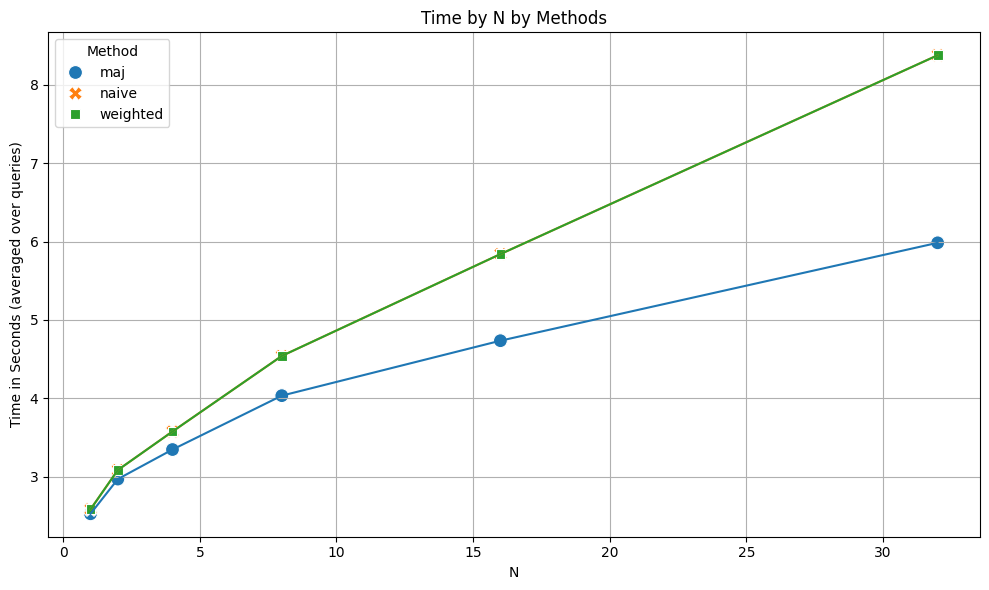

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_time, x="N", y="time", hue="method", style="method", s=100)
sns.lineplot(data=avg_time, x="N", y="time", hue="method", legend=False)

# Format the plot
plt.title("Time by N by Methods")
plt.xlabel("N")
plt.ylabel("Time in Seconds (averaged over queries)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Method")

plt.show()

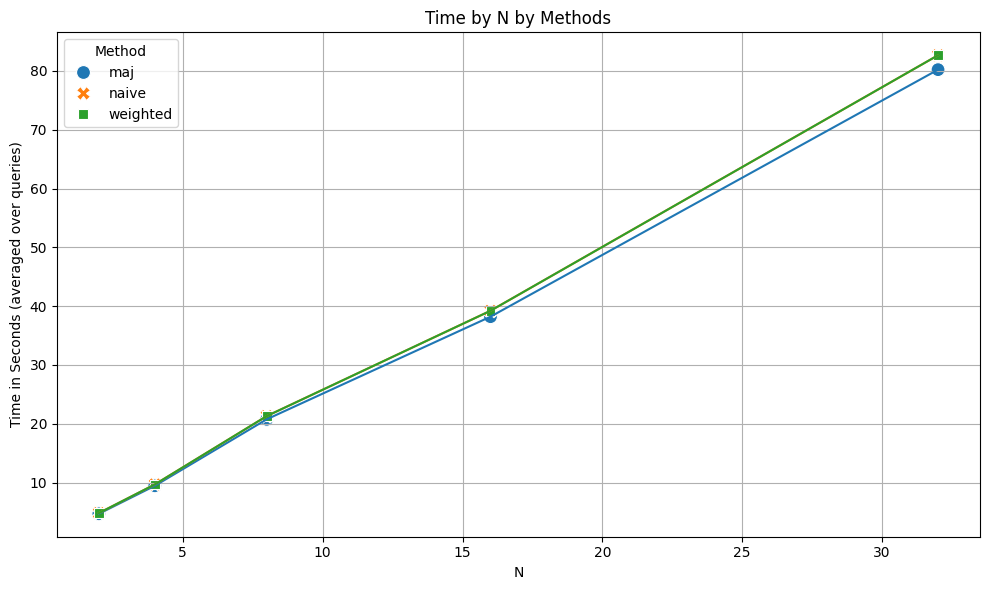

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_time, x="N", y="time", hue="method", style="method", s=100)
sns.lineplot(data=avg_time, x="N", y="time", hue="method", legend=False)

# Format the plot
plt.title("Time by N by Methods")
plt.xlabel("N")
plt.ylabel("Time in Seconds (averaged over queries)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Method")

plt.show()

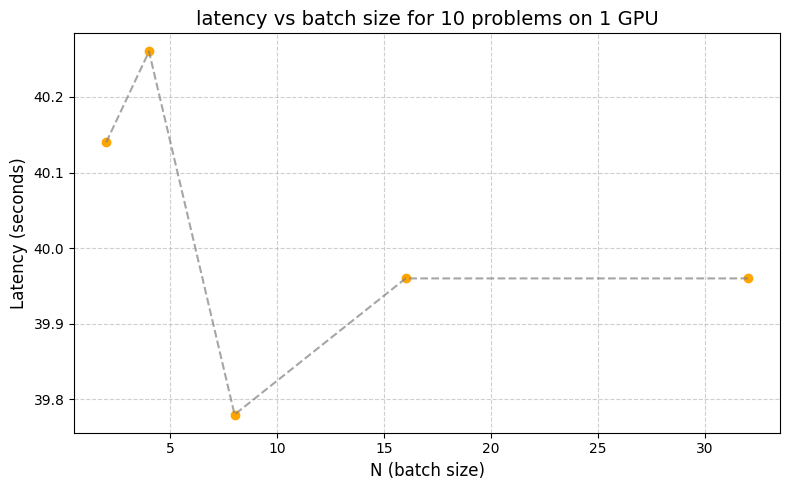

In [58]:
# Batch size tests (bread.out files)
import matplotlib.pyplot as plt

# Data for the plot
x_values = [2, 4, 8, 16, 32]
y_values = [40.14, 40.26, 39.78, 39.96, 39.96]

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x_values, y_values, color='orange')
plt.plot(x_values, y_values, linestyle='--', color='gray', alpha=0.7)

# Add labels and title
plt.xlabel("N (batch size)", fontsize=12)
plt.ylabel("Latency (seconds)", fontsize=12)
plt.title("latency vs batch size for 10 problems on 1 GPU", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [163]:
# create pivot table.

# Columns to melt (indicators)
sl_cols = [
    "indicator_weighted_1", "indicator_naive_1", "indicator_maj_1",
    "indicator_weighted_2", "indicator_naive_2", "indicator_maj_2",
    "indicator_weighted_4", "indicator_naive_4", "indicator_maj_4",
    "indicator_weighted_8", "indicator_naive_8", "indicator_maj_8",
    "indicator_weighted_16", "indicator_naive_16", "indicator_maj_16",
    "indicator_weighted_32", "indicator_naive_32", "indicator_maj_32",
]

# Melt the dataframe from wide to long
predictor_df = df_N8.melt(
    id_vars=['question', 'score', 'score_list', 'completion_tokens', 'sb_idx', 
             'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8', 'correctness_16', 'correctness_32'],
    value_vars=sl_cols,
    var_name='method_N',
    value_name='indicator'
) # indicator: whether the final answer is correct.

# # Extract method and N from 'method_N'
predictor_df[['drop', 'method', 'N']] = predictor_df['method_N'].str.extract(r'(indicator)_(\w+?)_(\d+)')
predictor_df.drop(columns=['method_N', 'drop'], inplace=True)

# Convert N to integer
predictor_df['N'] = predictor_df['N'].astype(int)

# Show result
predictor_df.head()

,question,score,score_list,completion_tokens,sb_idx,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,correctness_32,indicator,method,N
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,weighted,1
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0,weighted,1
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,weighted,1
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, True, False, True, True]","[True, True, True, True, True, False, True, Tr...","[True, True, True, True, True, False, True, Tr...",1,weighted,1
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,[True],"[True, True]","[True, True, False, False]","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",1,weighted,1


In [164]:
predictor_df.shape

(9000, 14)

In [165]:
# sanity check that melting worked correctly.
# predictor_df[predictor_df["sb_idx"] == 1]
# type(predictor_df["completion_tokens"][0]) 

### change completion_tokens to a list of ints.
predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [166]:
predictor_df.shape

(9000, 14)

In [169]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
w_latency = pd.merge(
    predictor_df,
    latencies,
    on=["sb_idx", "N", "method"],
    how="outer"
)
w_latency.head()

,question,score,score_list,completion_tokens,sb_idx,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,correctness_32,indicator,method,N,time
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,maj,1,1.52
1,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,naive,1,2.37
2,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,weighted,1,2.37
3,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,maj,2,2.13
4,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",1,naive,2,3.56


In [170]:
w_latency.shape

(9000, 15)

In [171]:
# filter for only rows with N=32.
# w_latency[w_latency["N"] == 32]
# merge in latency column.
predictor_df = w_latency

In [173]:
# Compute length of question (aka, length of the string)
predictor_df["question_length"] = predictor_df["question"].str.len()
predictor_df["token_count"] = predictor_df["completion_tokens"].apply(sum)
predictor_df = pd.get_dummies(predictor_df, columns=["method"])

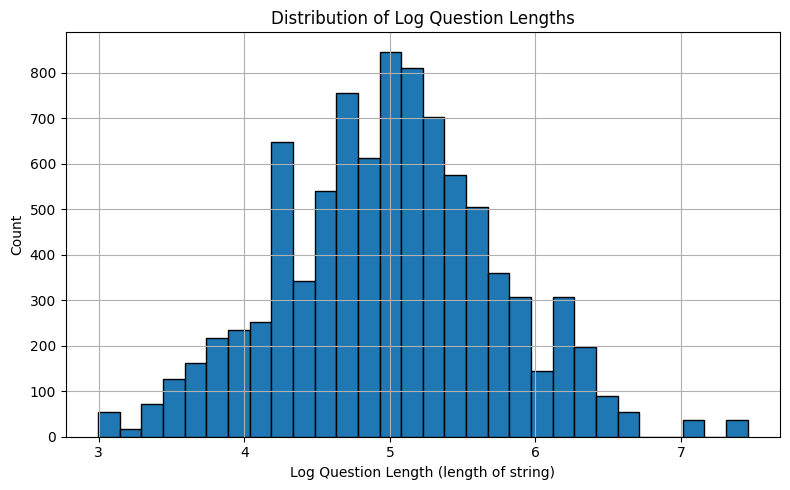

In [41]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(8, 5))
plt.hist(np.log(predictor_df["question_length"]), bins=30, edgecolor='black')

plt.xlabel("Log Question Length (length of string)")
plt.ylabel("Count")
plt.title("Distribution of Log Question Lengths")
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

### Prepare Features for Difficulty Probe.

In [174]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [175]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: False
CUDA device name: No GPU


To test out: different embedding models.

In [176]:
local_model_path = "/u/jhjenny9/.cache/huggingface/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594"
tokenizer = BertTokenizer.from_pretrained(local_model_path)
model = BertModel.from_pretrained(local_model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [177]:
# Set device to match model
device = model.device
device

device(type='cpu')

In [178]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token is at position 0
    return cls_embedding.squeeze().numpy()

In [299]:
# create train/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = predictor_df['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=6
)

# Divide queries (represented by sb_idx) into train and test
df_train = predictor_df[predictor_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = predictor_df[predictor_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [180]:
# (Training Data) Extract features: CLS + decoding parameters
cls_features = []

## Scaling factors
NUM_SAMPLES_SCALE = 1.0 
QUESTION_LENGTH_SCALE = 1.0
METHOD_SCALE = 1.0

for _, row in df_train.iterrows():
    cls_vec = get_cls_embedding(row["question"])  # e.g., shape (768,)
    
    # Scalar features
    num_samples = row["N"] * NUM_SAMPLES_SCALE
    question_length = np.log(row["question_length"]) * QUESTION_LENGTH_SCALE
    method_maj = row["method_maj"] * METHOD_SCALE
    method_naive = row["method_naive"] * METHOD_SCALE
    method_weighted = row["method_weighted"] * METHOD_SCALE

    # Concatenate features
    features = np.concatenate([
        cls_vec, 
        [num_samples, question_length, method_maj, method_naive, method_weighted]
    ]) 

    cls_features.append(features)

In [ ]:
X_train = np.array(cls_features)
y_train = df_train["indicator"].values.astype(int)
# y_train = df_train["sl"].values

## save X_train and y_train hard labels as .npz file.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_Xy_train.npz" (min)
# np.savez(output_file, X_train=X_train, y_train=y_train)

In [ ]:
# load X_train and y_train hard labels from .npz file.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_Xy_train.npz"
# data = np.load(output_file)
# X_train = data['X_train']
# y_train = data['y_train']

In [182]:
X_train.shape

(7200, 773)

### Create Testing Data

In [183]:
# (Testing Data) Extract features: CLS + decoding parameters
cls_features = []

NUM_SAMPLES_SCALE = 1.0
QUESTION_LENGTH_SCALE = 1.0
METHOD_SCALE = 1.0

for _, row in df_test.iterrows():
    cls_vec = get_cls_embedding(row["question"])  # e.g., shape (768,)
    
    # Scalar features
    num_samples = row["N"] * NUM_SAMPLES_SCALE
    question_length = np.log(row["question_length"]) * QUESTION_LENGTH_SCALE
    method_maj = row["method_maj"] * METHOD_SCALE
    method_naive = row["method_naive"] * METHOD_SCALE
    method_weighted = row["method_weighted"] * METHOD_SCALE

    # Concatenate features
    features = np.concatenate([cls_vec, [num_samples, question_length, method_maj, method_naive, method_weighted]]) 
    cls_features.append(features)

In [184]:
X_test = np.array(cls_features)
y_test = df_test["indicator"].values.astype(int)
# y_test = df_test["sl"].values

### Train MLP.

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [186]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [187]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7200, 773), (7200,), (1800, 773), (1800,))

### MLP Classifier from sklearn

In [ ]:
# Load the training data (can be from any training data, random seed is/was consistently 6.)
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_X_train.npy"
X_train = np.load(output_file)
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_train.npy"
y_train = np.load(output_file)

In [286]:
# 2-layer MLP Binary Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
# print train/test losses.

mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

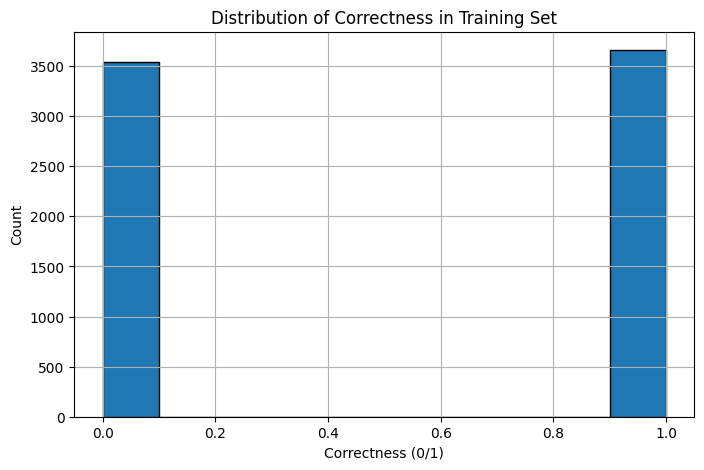

In [288]:
# create histogram of y_train
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=10, edgecolor='black')
plt.xlabel("Correctness (0/1)")
plt.ylabel("Count")
plt.title("Distribution of Correctness in Training Set")
plt.grid(True)

In [190]:
from sklearn.calibration import CalibrationDisplay

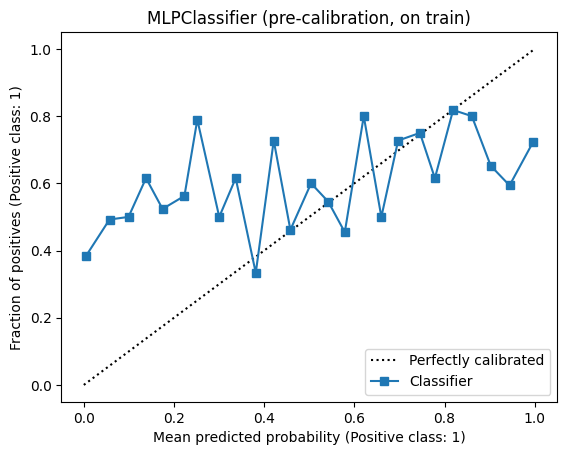

In [290]:
# Predict probabilities instead of labels
y_proba = mlp_clf.predict_proba(X_test)[:, 1]  # use probabilities for the positive class
# y_proba = hardLabel_preds_numpy  # use the soft label predictions directly
# Create calibration plot
disp = CalibrationDisplay.from_predictions(y_test, y_proba, n_bins=25)

plt.title("MLPClassifier (pre-calibration, on train)")
# Show plot
plt.show()

Each point represents a group of test samples (i.e., the dot at "Fraction of positive" of 0.4 represents a group of test samples where 0.4 of the samples belong to the negative class)

In [39]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

Split train data into train and validate.

In [40]:
X_train_remain, X_calib, y_train_remain, y_calib = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [41]:
base_mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
base_mlp.fit(X_train_remain, y_train_remain)

,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


Calibrate using validation set

In [48]:
calibrated_mlp = CalibratedClassifierCV(estimator=base_mlp, method='isotonic', ensemble=False, cv='prefit')
calibrated_mlp.fit(X_calib, y_calib)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,MLPClassifier...ndom_state=42)
,method,'isotonic'
,cv,'prefit'
,n_jobs,None
,ensemble,False
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'


Use calibrated MLP to make predictions

In [51]:
y_proba_base = base_mlp.predict_proba(X_test)[:, 1]
y_proba_calibrated = calibrated_mlp.predict_proba(X_test)[:, 1]

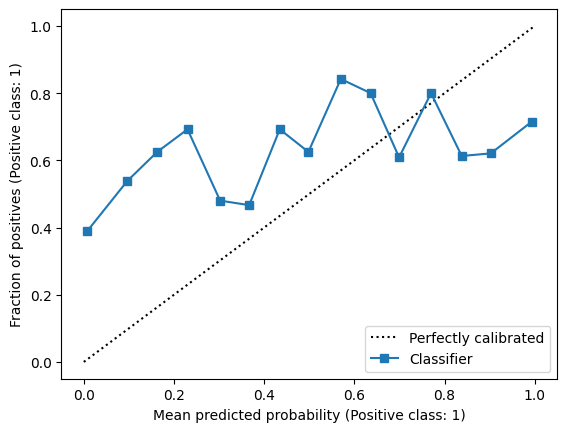

In [ ]:
CalibrationDisplay.from_predictions(y_test, y_proba_base, n_bins=15)
plt.show()

#### Test the probe.

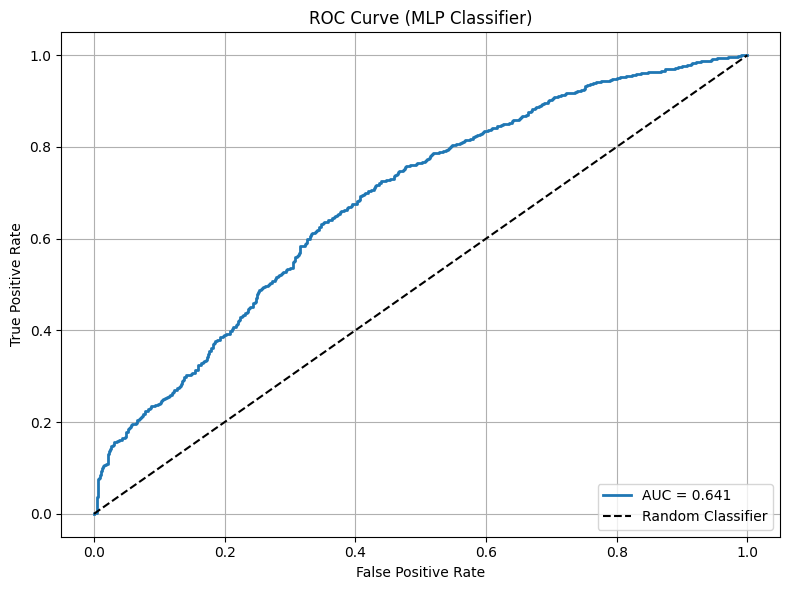

In [291]:
# AUC with all features.

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_proba = mlp_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute AUC
auc = roc_auc_score(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MLP Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
# plt.show()

# plt.savefig("figs/roc_all_mlp.png")

In [292]:
# predict probability of positive class (correct answer) for test set.
y_proba = mlp_clf.predict_proba(X_test)[:, 1]

In [301]:
# df_train['predicted_prob'] = y_proba
# df_train['predicted_prob'] = y_proba_train # sklearn MLPClassifier predictions (hard label version)
df_test['predicted_prob'] = y_proba

In [302]:
df_test.head(5)

,question,score,score_list,completion_tokens,sb_idx,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,correctness_32,indicator,N,time,question_length,token_count,method_maj,method_naive,method_weighted,predicted_prob
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.62,113,14054,True,False,False,0.072960
1,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.67,113,14054,False,True,False,0.865780
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.67,113,14054,False,False,True,0.944280
3,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,2,2.11,113,14054,True,False,False,0.845886
4,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,2,2.20,113,14054,False,True,False,0.997483


In [303]:
# there should be 18 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,18
1,10,18
2,12,18
3,13,18
4,16,18
...,...,...
95,478,18
96,480,18
97,486,18
98,495,18


In [304]:
# Transform method columns into a single 'method' column.
def decode_method(row):
    if row["method_maj"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    else:
        return "unknown"

# Apply the function row-wise
df_test["method"] = df_test.apply(decode_method, axis=1)
# df_train["method"] = df_train.apply(decode_method, axis=1)

# drop the one-hot columns
df_test = df_test.drop(columns=["method_maj", "method_naive", "method_weighted"])
# df_train = df_train.drop(columns=["method_maj", "method_naive", "method_weighted"])

In [305]:
df_test.head()

,question,score,score_list,completion_tokens,sb_idx,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,correctness_32,indicator,N,time,question_length,token_count,predicted_prob,method
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.62,113,14054,0.072960,majority
1,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.67,113,14054,0.865780,naive
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,1,2.67,113,14054,0.944280,weighted
3,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,2,2.11,113,14054,0.845886,majority
4,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",1,2,2.20,113,14054,0.997483,naive


#### create a plot of the predicted prob vs. the true indicator.

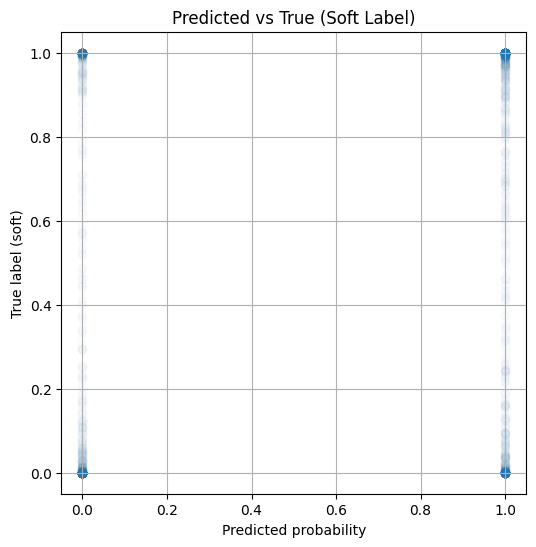

In [307]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_proba, alpha=0.01)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

In [ ]:
# df_test.head()

# # save test set with hard labels.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_test_set.csv"
# df_test.to_csv(output_file, index=False)
# print(f"Test set with hard labels saved to {output_file}")

# save train set with hard labels.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_train_set.csv"
# df_train.to_csv(output_file, index=False)
# print(f"Train set with hard labels saved to {output_file}")

Train set with hard labels saved to /dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_train_set.csv


In [ ]:
# # read prediction-with-hardLabel test set.
# df_test = pd.read_csv(output_file)
# df_test.head()

# read prediction-with-hardLabel (trained on PyTorch MLP) train set.
# df_train = pd.read_csv(output_file)
# df_train.shape

(7200, 16)

In [203]:
# turn completion_tokens into a list of ints.
df_test["completion_tokens"] = df_test["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# df_train["completion_tokens"] = df_train["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [204]:
df_test["token_count"] = df_test.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
# df_train["token_count"] = df_train.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)

START HERE IF YOU HAVE THE DATA FOR THE ROUTER (Best-of-32).

In [ ]:
# save df_test to csv
# df_test.to_csv("df_router_mv_bon.csv", index=False)
# df_test.to_csv("df_router_mv_bo32.csv", index=False)  # Bo32.
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/hardlabel_test_set.csv"
# df_train.to_csv(output_file, index=False)

# load in csv.
df_test = pd.read_csv("df_router_mv_bo32.csv") # Bo32.
# df_train = pd.read_csv(output_file)  # Bo32 train set.

Inspect the accuracy of the predictor.

In [ ]:
latencies_for_df_test = w_latency[["sb_idx", "N", "method", "time"]]
# Rename "maj" to "majority"
latencies_for_df_test["method"] = latencies_for_df_test["method"].replace({"maj": "majority"})

/tmp/ipykernel_3604023/3142411370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latencies_for_df_test["method"] = latencies_for_df_test["method"].replace({"maj": "majority"})


In [ ]:
latencies_for_df_test.shape
# write as csv file called "latencies_df.csv"
# latencies_for_df_test.to_csv("latencies_df.csv", index=False)

In [ ]:
# Combine the columns df_test and latencies_for_df_test.
df_test_w_time = df_test.merge(
    latencies_for_df_test,
    on=["sb_idx", "N", "method"],
    how="left"
)

In [247]:
df_test.shape

(1350, 19)

In [258]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test_w_time.groupby(["N", "method"])[
    ["indicator", "token_count", "time"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()
# config_summary_df = df_train.groupby(["N", "method"])[
#     ["indicator", "token_count"]
# ].mean().reset_index() # mean indicator is percentage of questions (out of 100 questions) that are answered correctly.

In [ ]:
# config_summary_df = df_train.groupby(["N", "method"])[
#     ["sl", "token_count"]
# ].mean().reset_index()

In [259]:
config_summary_df.head(20)

,N,method,indicator,token_count,time
0,1,majority,0.400000,497.320000,2.372667
1,1,naive,0.400000,497.320000,2.426400
2,1,weighted,0.400000,497.320000,2.426400
3,2,majority,0.400000,977.666667,2.827467
4,2,naive,0.453333,977.666667,2.934800
5,2,weighted,0.453333,977.666667,2.934800
6,4,majority,0.493333,1904.600000,2.870000
7,4,naive,0.586667,1904.600000,3.071600
8,4,weighted,0.586667,1904.600000,3.071600
9,8,majority,0.600000,3865.800000,3.833733


### Plot of Accuracies per Configuration
Config Summary DF.

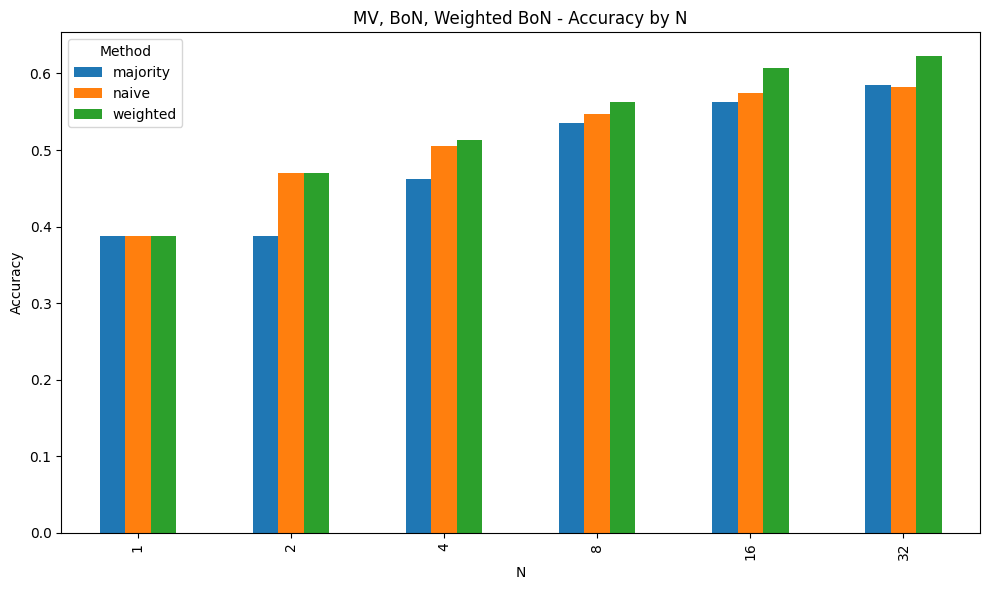

In [209]:
### TRAINING DF
# Pivot for plotting
pivot_df = config_summary_df.pivot(index="N", columns="method", values="indicator")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

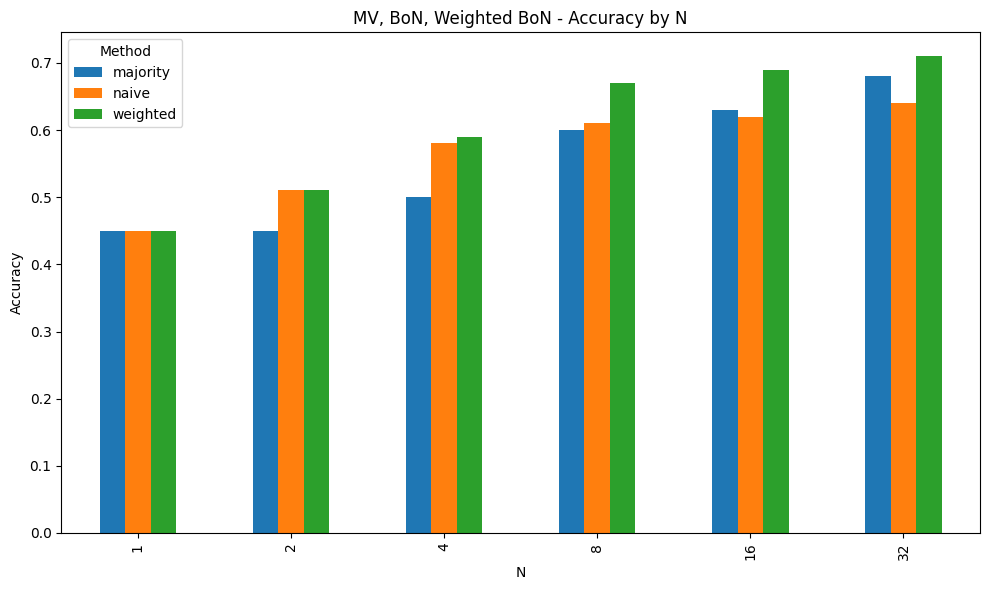

In [208]:
# TESTING DF
pivot_df = config_summary_df.pivot(index="N", columns="method", values="indicator")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [260]:
def compute_max_utility_pred(df, lambda_1, lambda_2):
    def get_max_utility(group): # verified correctness. (July 22nd)
        group = group.copy()
        group["utility"] = group["predicted_prob"] - lambda_1 * group["token_count"] - lambda_2 * group["time"]
        # print(group["predicted_prob"], group["indicator"], group["token_count"], group["N"], group["method"])
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "indicator": group.loc[idx_max, "indicator"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [262]:
lamb1_value = 0
lamb2_value = 0
# for large lambda values, the max-accuracy is 0/1 because N is small in BoN.
adaptive_router_0_lambda = compute_max_utility_pred(df_test_w_time, lamb1_value, lamb2_value)
adaptive_router_0_lambda.head(20) # 100 questions in the test set.

/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()


,sb_idx,max_utility,max_predicted_prob,indicator,max_cost,max_time,N,method
0,2,0.358136,0.358136,1,13382,5.08,32,weighted
1,10,0.002229,0.002229,1,15904,7.80,32,weighted
2,12,0.494268,0.494268,0,13838,6.51,32,weighted
3,13,0.205140,0.205140,1,760,1.38,4,naive
4,28,0.948774,0.948774,1,2076,3.67,4,naive
5,30,0.999369,0.999369,1,4911,2.42,16,weighted
6,32,0.983955,0.983955,1,11098,4.49,32,weighted
7,44,0.971193,0.971193,1,13494,5.36,32,weighted
8,53,0.865947,0.865947,1,8721,4.00,32,weighted
9,59,0.983496,0.983496,1,11698,4.54,32,weighted


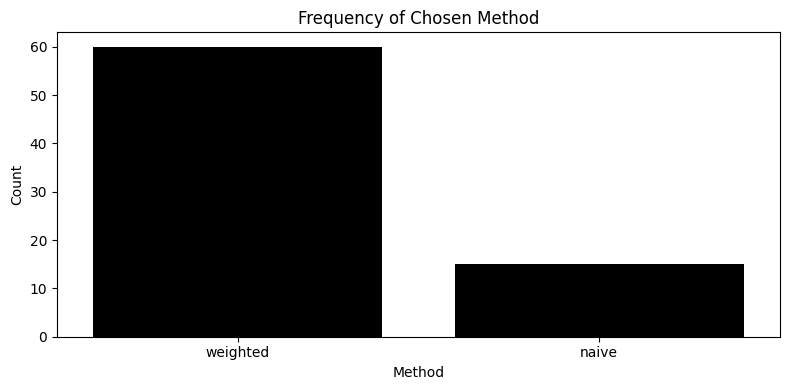

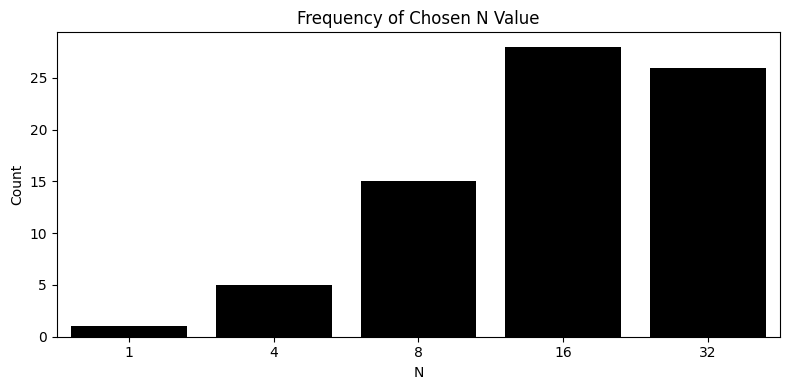

In [263]:
# Plot: Histogram of method counts
plt.figure(figsize=(8, 4))
sns.countplot(data=adaptive_router_0_lambda, x="method", order=adaptive_router_0_lambda["method"].value_counts().index, color="black")
plt.title("Frequency of Chosen Method")
plt.xlabel("Method")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot: Histogram of N values
plt.figure(figsize=(8, 4))
sns.countplot(data=adaptive_router_0_lambda, x="N", order=sorted(adaptive_router_0_lambda["N"].unique()), color="black")
plt.title("Frequency of Chosen N Value")
plt.xlabel("N")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

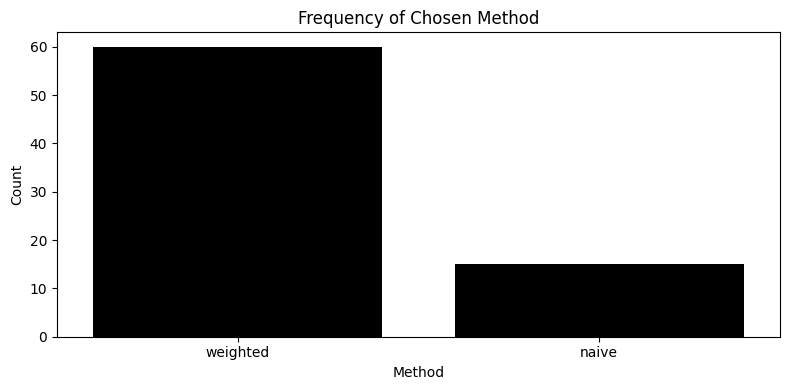

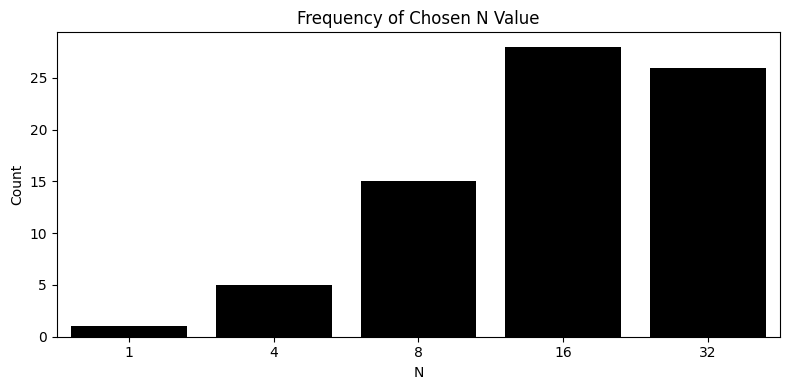

In [264]:
# Plot: Histogram of method counts
plt.figure(figsize=(8, 4))
sns.countplot(data=adaptive_router_0_lambda, x="method", order=adaptive_router_0_lambda["method"].value_counts().index, color="black")
plt.title("Frequency of Chosen Method")
plt.xlabel("Method")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot: Histogram of N values
plt.figure(figsize=(8, 4))
sns.countplot(data=adaptive_router_0_lambda, x="N", order=sorted(adaptive_router_0_lambda["N"].unique()), color="black")
plt.title("Frequency of Chosen N Value")
plt.xlabel("N")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [265]:
# average of indicator column to get the percentage of questions the router answers correctly.
average_accuracy = adaptive_router_0_lambda["indicator"].mean()
average_cost = adaptive_router_0_lambda["max_cost"].mean()
print(f"Average accuracy for lambda={0} is {average_accuracy:.4f}, average cost is: {average_cost:.4f}")
# print(f"Average cost is: {average_cost:.4f}")

Average accuracy for lambda=0 is 0.7067, average cost is: 9055.1333


In [266]:
# Sweep over lambda values 
lambda_2_list = np.logspace(-50, -1, num=100) 
lambda_1_list = [0] * len(lambda_2_list) # np.logspace(-50, -1, num=25) 

In [268]:
results = []

for l2 in lambda_2_list:
    # for l2 in lambda_2_list:
    l1 = 0
    adaptive_router = compute_max_utility_pred(df_test_w_time, l1, l2)
    # adaptive_router = compute_max_utility_pred(df_train, lambda_value)
    average_accuracy = adaptive_router["indicator"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    average_time = adaptive_router["max_time"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    
    
    results.append({
        "lambda_1": l1,
        "lambda_2": l2,
        "indicator": average_accuracy,
        "token_count": average_cost,
        "time": average_time,
        "predicted_prob": average_predicted_prob,
    })

# Convert to DataFrame
query_adaptive_df = pd.DataFrame(results)
print(query_adaptive_df)

/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

    lambda_1      lambda_2  indicator  token_count      time  predicted_prob
0          0  1.000000e-50   0.706667  9055.133333  5.763067        0.715616
1          0  3.125716e-50   0.706667  9055.133333  5.763067        0.715616
2          0  9.770100e-50   0.706667  9055.133333  5.763067        0.715616
3          0  3.053856e-49   0.706667  9055.133333  5.763067        0.715616
4          0  9.545485e-49   0.706667  9055.133333  5.763067        0.715616
..       ...           ...        ...          ...       ...             ...
95         0  1.047616e-03   0.640000  6346.506667  4.462933        0.715310
96         0  3.274549e-03   0.640000  6105.400000  4.332400        0.715071
97         0  1.023531e-02   0.560000  5671.186667  3.856800        0.712463
98         0  3.199267e-02   0.533333  4648.653333  3.304933        0.701148
99         0  1.000000e-01   0.533333  3331.586667  2.847333        0.674030

[100 rows x 6 columns]


/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3604023/3012907584.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [269]:
# the routed queries.
query_adaptive_df.head()

,lambda_1,lambda_2,indicator,token_count,time,predicted_prob
0,0,1.000000e-50,0.706667,9055.133333,5.763067,0.715616
1,0,3.125716e-50,0.706667,9055.133333,5.763067,0.715616
2,0,9.770100e-50,0.706667,9055.133333,5.763067,0.715616
3,0,3.053856e-49,0.706667,9055.133333,5.763067,0.715616
4,0,9.545485e-49,0.706667,9055.133333,5.763067,0.715616


In [270]:
# rename column indicator to accuracy.
config_summary_df

,N,method,indicator,token_count,time
0,1,majority,0.400000,497.320000,2.372667
1,1,naive,0.400000,497.320000,2.426400
2,1,weighted,0.400000,497.320000,2.426400
3,2,majority,0.400000,977.666667,2.827467
4,2,naive,0.453333,977.666667,2.934800
5,2,weighted,0.453333,977.666667,2.934800
6,4,majority,0.493333,1904.600000,2.870000
7,4,naive,0.586667,1904.600000,3.071600
8,4,weighted,0.586667,1904.600000,3.071600
9,8,majority,0.600000,3865.800000,3.833733


In [271]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["indicator", "token_count", "time"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [273]:
query_optimal_static_df.head(10)
# print the tail.
query_optimal_static_df.tail(10)


,lambda_1,lambda_2,indicator,token_count,time,predicted_prob,N,method
108,0.0,3.944206e-11,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
109,0.0,1.232847e-10,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
110,0.0,3.853529e-10,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
111,0.0,1.204504e-09,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
112,0.0,3.764936e-09,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
113,0.0,1.176812e-08,0.706667,9055.133333,5.763067,0.715616,-1.0,-1
114,-1.0,-1.000000e+00,0.720000,7759.253333,4.592000,-1.000000,16.0,majority
115,-1.0,-1.000000e+00,0.720000,7759.253333,5.661067,-1.000000,16.0,weighted
116,-1.0,-1.000000e+00,0.720000,15576.640000,5.688400,-1.000000,32.0,majority
117,-1.0,-1.000000e+00,0.773333,15576.640000,7.962400,-1.000000,32.0,weighted


['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'naivex2.0', 'weightedx2.0', 'majorityx4.0', 'qa', 'qa', 'qa', 'naivex4.0', 'weightedx4.0', 'naivex8.0', 'majorityx8.0', 'naivex16.0', 'naivex32.0', 'qa', 'qa', 'weightedx8.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'majorityx16.0', 'weightedx16.0', 'majorityx32.0', 'weightedx32.0']


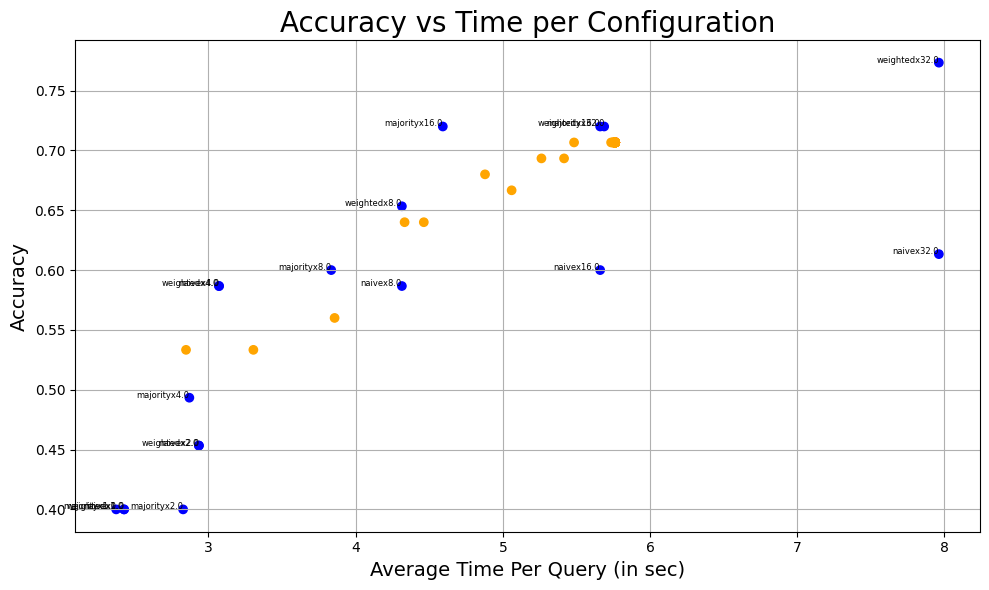

In [308]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["time"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["time"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        pass
        # plt.annotate(f"l: {round(query_optimal_static_df["lambda_1"][i], 7)}",
        #             (query_optimal_static_df["time"][i], query_optimal_static_df["indicator"][i]),
        #             textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Time Per Query (in sec)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Time per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx2.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'naivex2.0', 'weightedx2.0', 'majorityx4.0', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'naivex8.0', 'majorityx32.0', 'weightedx8.0', 'naivex16.0', 'weightedx16.0', 'naivex32.0', 'majorityx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 

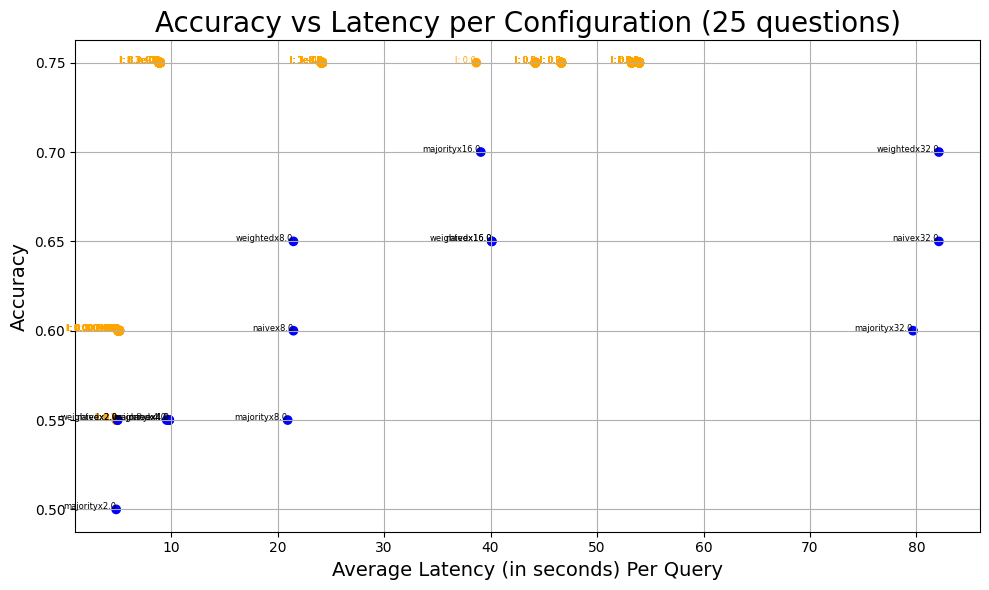

In [283]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["time"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["time"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda_1"][i], 7)}",
                    (query_optimal_static_df["time"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Latency (in seconds) Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Latency per Configuration (25 questions)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


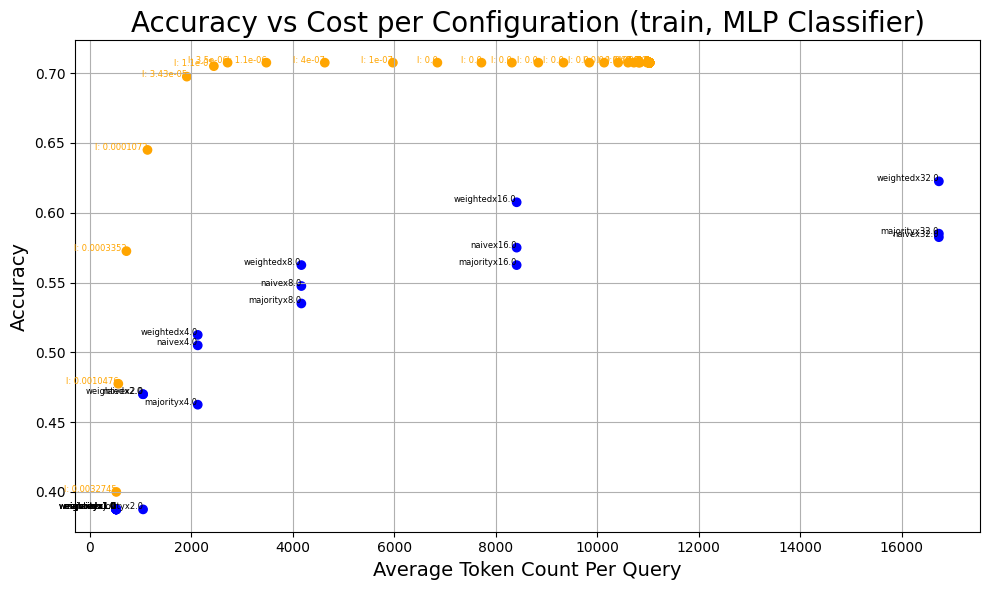

In [258]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


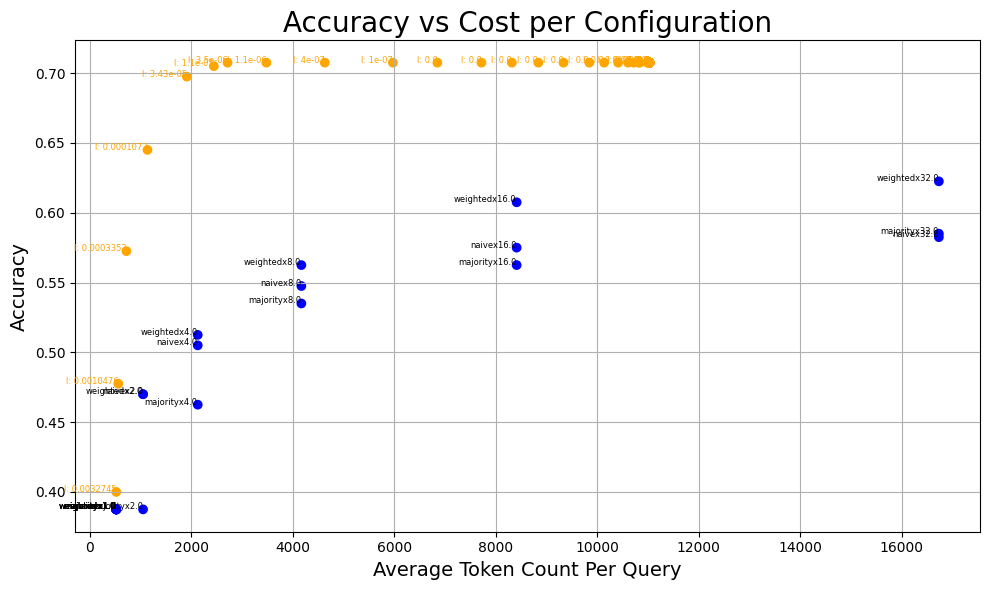

In [242]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).